# Compare Annotation-Only Meta-Analysis Results

This notebook compares automated meta-analysis results from the **annotation-only** pipeline against manual NeuroMetaBench meta-analyses.

The annotation-only results are stored in: `projects/social/coordinates/annotation-only/outputs/meta_analysis_results`

In [2]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from pathlib import Path
from nilearn import plotting
import json

## Setup Paths

In [ ]:
repos_dir = '/home/zorro/repos'

# Annotation-only meta-analysis results path
annotation_only_meta_results = 'autonima-results/projects/social/coordinates/annotation-only/outputs/meta_analysis_results'
annotation_only_annotation_path = 'autonima-results/projects/social/coordinates/annotation-only/outputs/nimads_annotation.json'

# Manual meta-analysis paths (NeuroMetaBench)
social_meta_path = 'autonima-results/projects/social/coordinates/analysis/nmb-results/social'
social_nimads_path = 'neurometabench/data/nimads/social'

# Mapping from NeuroMetaBench social analysis names to autonima-results social analysis names
mappings = {
    "Affiliation-Merged": 'affiliation_attachment',
    "Self-Merged": 'perception_self',
    "Others-Merged": 'perception_others',
    "SocComm-Merged": 'social_communication',
    "ALL-Merged": 'social_processing_all',
}

# Result file to load
result_file = 'z.nii.gz'

# Threshold for Dice coefficient (z-score threshold)
dice_threshold = 1.96

## Load Manual Meta-Analysis Data

In [6]:
def load_nifti_data(base_dir, subdir, filename):
    """Load a NIfTI file and return the data array."""
    filepath = os.path.join(base_dir, subdir, filename)
    if not os.path.exists(filepath):
        print(f"Warning: File not found: {filepath}")
        return None, None
    
    img = nib.load(filepath)
    data = img.get_fdata()
    return data, filepath


# Load manual meta-analysis results
manual_data = {}
manual_paths = {}
for manual_name in mappings.keys():
    manual_dir = os.path.join(repos_dir, social_meta_path, manual_name)
    data, filepath = load_nifti_data(repos_dir, os.path.join(social_meta_path, manual_name), result_file)
    if data is not None:
        manual_data[manual_name] = data
        manual_paths[manual_name] = filepath

print(f"\nLoaded {len(manual_data)} manual meta-analysis maps")




Loaded 5 manual meta-analysis maps


## Load Annotation-Only NIfTI Files

In [7]:
# Load annotation-only automated results
annotation_only_data = {}
annotation_only_paths = {}

# Get all annotation types that exist in the annotation-only folder
annotation_only_dir = os.path.join(repos_dir, annotation_only_meta_results)
if os.path.exists(annotation_only_dir):
    available_annotations = [d for d in os.listdir(annotation_only_dir) 
                           if os.path.isdir(os.path.join(annotation_only_dir, d))]
    print(f"Found {len(available_annotations)} annotation types in annotation-only results:")
    print(available_annotations)
    
    for annotation_name in available_annotations:
        data, filepath = load_nifti_data(
            repos_dir,
            os.path.join(annotation_only_meta_results, annotation_name),
            result_file
        )
        if data is not None:
            annotation_only_data[annotation_name] = data
            annotation_only_paths[annotation_name] = filepath
    
    print(f"\nLoaded {len(annotation_only_data)} annotation-only maps")
else:
    print(f"Warning: Annotation-only directory not found: {annotation_only_dir}")

Found 7 annotation types in annotation-only results:
['social_communication', 'perception_self', 'all_analyses', 'perception_others', 'all_studies', 'affiliation_attachment', 'social_processing_all']

Loaded 7 annotation-only maps


## Create Common Mask

In [8]:
def create_common_mask(data_dict_auto, data_dict_manual):
    """Create a mask of voxels that are valid (finite) across all images."""
    masks = []
    
    for _, data in data_dict_auto.items():
        masks.append(np.isfinite(data))
    
    for _, data in data_dict_manual.items():
        masks.append(np.isfinite(data))
    
    if len(masks) == 0:
        return None
    
    # Combine all masks
    common_mask = masks[0]
    for mask in masks[1:]:
        common_mask = common_mask & mask
    
    print(f"Common mask: {np.sum(common_mask)} valid voxels")
    return common_mask

# Create common mask (including manual data)
common_mask = create_common_mask(annotation_only_data, manual_data)

# Apply mask to all data
annotation_only_data_masked = {
    name: data.flatten()[common_mask.flatten()] 
    for name, data in annotation_only_data.items()
}
manual_data_masked = {
    name: data.flatten()[common_mask.flatten()] 
    for name, data in manual_data.items()
}

Common mask: 902629 valid voxels


## Compute Dice Coefficients

In [9]:
def compute_dice_coefficient(img1, img2, threshold=0):
    """Compute Dice coefficient between two binary masks."""
    binary1 = img1 > threshold
    binary2 = img2 > threshold
    
    intersection = np.sum(binary1 & binary2)
    sum_volumes = np.sum(binary1) + np.sum(binary2)
    
    if sum_volumes == 0:
        return 0.0
    
    dice = (2.0 * intersection) / sum_volumes
    return dice

def compute_dice_matrix(data_dict_1, data_dict_2, threshold=0):
    """Compute Dice coefficient matrix between two sets of data."""
    names_1 = list(data_dict_1.keys())
    names_2 = list(data_dict_2.keys())
    
    dice_matrix = np.zeros((len(names_1), len(names_2)))
    for i, name_1 in enumerate(names_1):
        for j, name_2 in enumerate(names_2):
            vec_1 = data_dict_1[name_1]
            vec_2 = data_dict_2[name_2]
            dice = compute_dice_coefficient(vec_1, vec_2, threshold)
            dice_matrix[i, j] = dice
    
    return dice_matrix, names_1, names_2

## Compare Annotation-Only Analyses to Manual Meta-Analyses

In [10]:
# Align annotation-only results to manual using mappings
manual_aligned = {}
for manual_name, auto_name in mappings.items():
    if manual_name in manual_data_masked:
        manual_aligned[auto_name] = manual_data_masked[manual_name]

annotation_only_aligned = {}
for manual_name, auto_name in mappings.items():
    if auto_name in annotation_only_data_masked:
        annotation_only_aligned[auto_name] = annotation_only_data_masked[auto_name]

print("Aligned maps:")
print(f"  Manual: {len(manual_aligned)} maps")
print(f"  Annotation-only: {len(annotation_only_aligned)} maps")

# Compute Dice matrix (annotation-only vs manual)
dice_auto_vs_manual, row_names, col_names = compute_dice_matrix(
    annotation_only_aligned, manual_aligned, dice_threshold
)

print(f"\nDice matrix shape (annotation-only vs manual): {dice_auto_vs_manual.shape}")

Aligned maps:
  Manual: 5 maps
  Annotation-only: 5 maps

Dice matrix shape (annotation-only vs manual): (5, 5)


## Visualize Annotation-Only vs Manual Dice Matrix

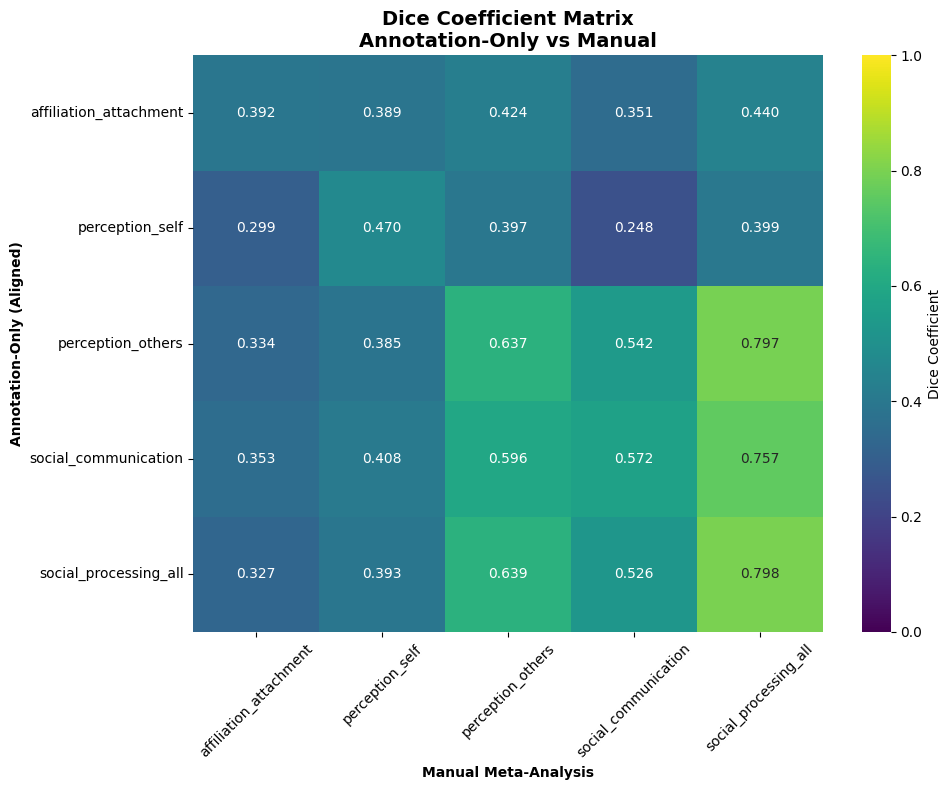

In [ ]:
# Visualize Dice matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    dice_auto_vs_manual, annot=True, fmt='.3f', cmap='viridis',
    xticklabels=col_names, yticklabels=row_names,
    vmin=0, vmax=1, ax=ax, cbar_kws={'label': 'Dice Coefficient'}
)
ax.set_title('Dice Coefficient Matrix\nAnnotation-Only vs Manual', fontsize=14, fontweight='bold')
ax.set_xlabel('Manual Meta-Analysis', fontweight='bold')
ax.set_ylabel('Annotation-Only (Aligned)', fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig('images/dice_coefficient_annotation_only_vs_manual.png', dpi=300, bbox_inches='tight')
plt.show()

## Diagonal Dice: Matching Annotation-Only vs Manual

,Annotation Type,Dice Coefficient
0,affiliation_attachment,0.392116
1,perception_self,0.470044
2,perception_others,0.637183
3,social_communication,0.572199
4,social_processing_all,0.797854


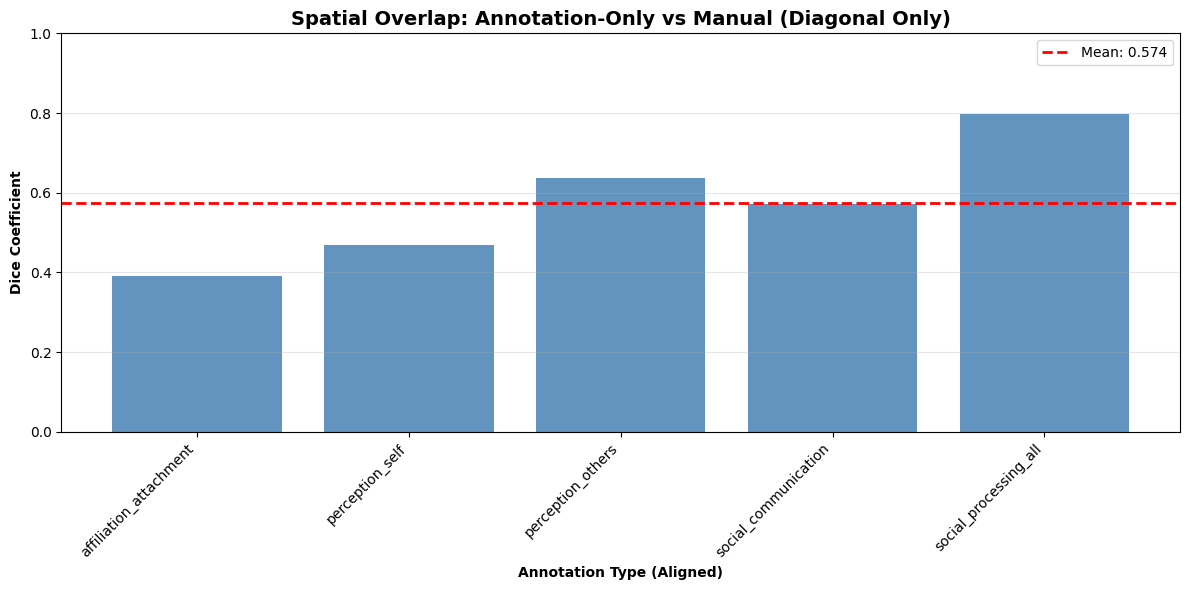


Mean diagonal Dice coefficient: 0.574


In [12]:
# Extract diagonal Dice (matching auto_name == manual mapped)
diag_order = [auto_name for _, auto_name in mappings.items() if auto_name in manual_aligned]
diag_values = []

for auto_name in diag_order:
    if auto_name in annotation_only_aligned and auto_name in manual_aligned:
        dice_val = compute_dice_coefficient(
            annotation_only_aligned[auto_name], 
            manual_aligned[auto_name], 
            dice_threshold
        )
        diag_values.append(dice_val)
    else:
        diag_values.append(np.nan)

diag_table = pd.DataFrame({
    'Annotation Type': diag_order,
    'Dice Coefficient': diag_values
})

display(diag_table)

# Bar plot
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(diag_table))
ax.bar(x, diag_table['Dice Coefficient'].values, alpha=0.85, color='steelblue')

ax.set_ylabel('Dice Coefficient', fontweight='bold')
ax.set_xlabel('Annotation Type (Aligned)', fontweight='bold')
ax.set_title('Spatial Overlap: Annotation-Only vs Manual (Diagonal Only)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(diag_table['Annotation Type'], rotation=45, ha='right')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add mean line
mean_dice = np.nanmean(diag_table['Dice Coefficient'])
ax.axhline(mean_dice, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_dice:.3f}')
ax.legend()

plt.tight_layout()
plt.savefig('images/dice_diagonal_annotation_only_vs_manual.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nMean diagonal Dice coefficient: {mean_dice:.3f}")

## Summary Statistics

In [13]:
# Summary statistics
print("\nSummary Statistics:")
print("=" * 50)
print(f"Number of comparisons: {len(diag_values)}")
print(f"Mean Dice: {np.nanmean(diag_values):.3f}")
print(f"Median Dice: {np.nanmedian(diag_values):.3f}")
print(f"Std Dice: {np.nanstd(diag_values):.3f}")
print(f"Min Dice: {np.nanmin(diag_values):.3f}")
print(f"Max Dice: {np.nanmax(diag_values):.3f}")


Summary Statistics:
Number of comparisons: 5
Mean Dice: 0.574
Median Dice: 0.572
Std Dice: 0.140
Min Dice: 0.392
Max Dice: 0.798


## Compare studies and analyses included

In [36]:
import os
import json
def compute_annotation_counts(annotation_path):
    """Load annotation JSON and compute counts per annotation type."""
    with open(os.path.join(repos_dir, annotation_path), 'r') as f:
        meta = json.load(f)

    # Handle list format
    if isinstance(meta, list):
        meta = meta[0]

    notes = meta["notes"]

    # Count analyses per boolean column
    analyses = {k: set() for k in meta["note_keys"].keys()}
    pmids = {k: set() for k in meta["note_keys"].keys()}
    for note in notes:
        analysis = note['analysis']
        pmid, _, analysis_id = analysis.split("_")
        for k in analyses:
            try:
                if bool(note['note'].get(k, False)):
                    analyses[k].add(analysis)
                    pmids[k].add(pmid)
            except Exception:
                pass

    pmids = {k: {p for p in v if p is not None} for k, v in pmids.items()}
    return analyses, pmids, list(analyses.keys())


In [38]:
analyses, pmids, annotation_names = compute_annotation_counts(annotation_only_annotation_path)
pmids_per_annotation = {k: len(v) for k, v in pmids.items()}
analyses_per_annotation = {k: len(v) for k, v in analyses.items()}

In [32]:
pmids_per_annotation

{'all_analyses': 134,
 'all_studies': 134,
 'social_processing_all': 132,
 'affiliation_attachment': 60,
 'social_communication': 101,
 'perception_self': 47,
 'perception_others': 124}

In [39]:
analyses_per_annotation

{'all_analyses': 637,
 'all_studies': 637,
 'social_processing_all': 610,
 'affiliation_attachment': 196,
 'social_communication': 423,
 'perception_self': 169,
 'perception_others': 550}

### Load manual meta-analysis counts (NeuroMetaBench)